In [1]:
import findspark
findspark.init()
findspark.find()

from pyspark import SparkContext

from pyspark.sql import SparkSession

from pyspark import SparkConf

import pyspark.sql as pysql

from pyspark import StorageLevel

In [41]:
import matplotlib.pyplot as plt

In [2]:
import os
import sys

#os.environ['PYSPARK_PYTHON'] = sys.executable
#os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [3]:
conf = SparkConf().setAppName("Tarea") \
    .setMaster("local[8]") \
    .set("spark.executor.cores","2") \
    .set("spark.executor.memory", "4g") \
    .set("spark.driver.memory","4g")

In [4]:
spark : SparkSession = SparkSession.builder.config(conf=conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/07 01:14:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
spark

In [6]:
columnas = [
    'Airline', # Aerolinea
    'CRSDepTime', #Hora de salida programada
    'DepTime', #Hora de salida actual
    'DepDelay', #Diferencia en minutos entre CRSDepTime y DepTime, tiempos negativos significa salidas tempranas
    'CRSArrTime',
    'ArrTime', #Hora de llegada
    'ArrDelay', #Diferencia de minutos entre la llegada programada y la hora de llegada, tiempos negativos significa llegadas tempranas
    'ActualElapsedTime', #Tiempo de vuelo verdadero
    'CRSElapsedTime', #Tiempo de vuelo programado
    'Distance', #Distancia entre aeropuertos en millas
    'Year', #Año del vuelo
    'Month', #Mes del vuelo
    'DayofMonth', #Dia del mes del vuelo
    'DayOfWeek', #Dia de la semana del vuelo
    'Tail_Number', #Numero de la cola, código para identificar la aeronave
    'Flight_Number_Operating_Airline', #Numero del vuelo
    
    'Origin', #Aeropuerto de origen
    'OriginAirportID', 'OriginAirportSeqID', #codigos del aeropuerto de origen
    'OriginCityName', #Nombre de la ciudad del aeropuerto de origen
    'OriginStateName', #Nombre de estado del aeropuerto de origen
    
    'Dest', #Aeropuerto de destino
    'DestAirportID', 'DestAirportSeqID', #codigos del aeropuerto de destino
    'DestCityName', #Nombre de la ciudad del aeropuerto de destino
    'DestStateName', #Nombre de estado del aeropuerto de destino
    
    'Cancelled', #El vuelo fue cancelado, 1 = Sí
    
    'Diverted', #Si el vuelo fue desviado, 1 = Sí
]

In [7]:
import zipfile
import pathlib

direccion = pathlib.Path.cwd()

path_datos_zip = pathlib.Path.joinpath(direccion.parent, 'Datos', 'data.zip')

path_guardar = pathlib.Path.joinpath(direccion.parent, 'Datos')

archivos_datos = [
    pathlib.Path.joinpath(direccion.parent, 'Datos', 'Combined_Flights_2022.csv').as_posix(),
    pathlib.Path.joinpath(direccion.parent, 'Datos', 'Combined_Flights_2021.csv').as_posix(),
    pathlib.Path.joinpath(direccion.parent, 'Datos', 'Combined_Flights_2020.csv').as_posix(),
    pathlib.Path.joinpath(direccion.parent, 'Datos', 'Combined_Flights_2019.csv').as_posix(),
    pathlib.Path.joinpath(direccion.parent, 'Datos', 'Combined_Flights_2018.csv').as_posix()
]

archivos_datos_en_zip  = [
    'Combined_Flights_2022.csv',
    'Combined_Flights_2021.csv',
    'Combined_Flights_2020.csv',
    'Combined_Flights_2019.csv',
    'Combined_Flights_2018.csv'
]

In [8]:
with zipfile.ZipFile(path_datos_zip, mode="r") as archivo_zip:
    for archivo in archivos_datos_en_zip:
        
        if os.path.isfile(path=pathlib.Path.joinpath(path_guardar,archivo).as_posix()):
            continue
        
        archivo_zip.extract(archivo, path_guardar)

In [9]:
archivos_datos

['/home/Andree/Documents/Maestria/DatosMasivos/DatosMasivos/Datos/Combined_Flights_2022.csv',
 '/home/Andree/Documents/Maestria/DatosMasivos/DatosMasivos/Datos/Combined_Flights_2021.csv',
 '/home/Andree/Documents/Maestria/DatosMasivos/DatosMasivos/Datos/Combined_Flights_2020.csv',
 '/home/Andree/Documents/Maestria/DatosMasivos/DatosMasivos/Datos/Combined_Flights_2019.csv',
 '/home/Andree/Documents/Maestria/DatosMasivos/DatosMasivos/Datos/Combined_Flights_2018.csv']

In [10]:
df = spark.read.option("header","true").csv(archivos_datos)

In [11]:
df = df.select(columnas)

In [12]:
df = df.persist(StorageLevel.DISK_ONLY)

24/11/07 01:14:59 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [13]:
df = df.withColumn("CRSDepTime", df["CRSDepTime"].cast(pysql.types.FloatType()))
df = df.withColumn("DepTime", df["DepTime"].cast(pysql.types.FloatType()))
df = df.withColumn("DepDelay", df["DepDelay"].cast(pysql.types.FloatType()))
df = df.withColumn("ArrTime", df["ArrTime"].cast(pysql.types.FloatType()))
df = df.withColumn("ArrDelay", df["ArrDelay"].cast(pysql.types.FloatType()))
df = df.withColumn("ActualElapsedTime", df["ActualElapsedTime"].cast(pysql.types.FloatType()))
df = df.withColumn("CRSElapsedTime", df["CRSElapsedTime"].cast(pysql.types.FloatType()))
df = df.withColumn("Distance", df["Distance"].cast(pysql.types.FloatType()))
df = df.withColumn("Year", df["Year"].cast(pysql.types.IntegerType()))
df = df.withColumn("Month", df["Month"].cast(pysql.types.IntegerType()))
df = df.withColumn("DayofMonth", df["DayofMonth"].cast(pysql.types.IntegerType()))
df = df.withColumn("DayOfWeek", df["DayOfWeek"].cast(pysql.types.IntegerType()))

df = df.withColumn("Cancelled", pysql.functions.when(df["Cancelled"] == "False",0).otherwise(1))
df = df.withColumn("Diverted", pysql.functions.when(df["Diverted"] == "False",0).otherwise(1))

24/11/07 01:14:59 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [14]:
df.show(truncate=False)

+-----------------------------------------+----------+-------+--------+----------+-------+--------+-----------------+--------------+--------+----+-----+----------+---------+-----------+-------------------------------+------+---------------+------------------+------------------------+---------------+----+-------------+----------------+-------------------+-------------+---------+--------+
|Airline                                  |CRSDepTime|DepTime|DepDelay|CRSArrTime|ArrTime|ArrDelay|ActualElapsedTime|CRSElapsedTime|Distance|Year|Month|DayofMonth|DayOfWeek|Tail_Number|Flight_Number_Operating_Airline|Origin|OriginAirportID|OriginAirportSeqID|OriginCityName          |OriginStateName|Dest|DestAirportID|DestAirportSeqID|DestCityName       |DestStateName|Cancelled|Diverted|
+-----------------------------------------+----------+-------+--------+----------+-------+--------+-----------------+--------------+--------+----+-----+----------+---------+-----------+-------------------------------+---

In [15]:
df.printSchema()

root
 |-- Airline: string (nullable = true)
 |-- CRSDepTime: float (nullable = true)
 |-- DepTime: float (nullable = true)
 |-- DepDelay: float (nullable = true)
 |-- CRSArrTime: string (nullable = true)
 |-- ArrTime: float (nullable = true)
 |-- ArrDelay: float (nullable = true)
 |-- ActualElapsedTime: float (nullable = true)
 |-- CRSElapsedTime: float (nullable = true)
 |-- Distance: float (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Operating_Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginAirportID: string (nullable = true)
 |-- OriginAirportSeqID: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestAirportID: string (nullable = true)
 |-- DestAir

In [16]:
df.count()

29193782

In [17]:
df.groupBy("Year").agg({
    "Cancelled" : "avg"
}).orderBy(pysql.functions.desc("avg(Cancelled)")).show(truncate=False)

+----+--------------------+
|Year|avg(Cancelled)      |
+----+--------------------+
|2020|0.059942493594194166|
|2022|0.030206570453799826|
|2019|0.0189860355396973  |
|2021|0.017588762507979014|
|2018|0.015532615099502383|
+----+--------------------+



In [18]:
df.groupBy("Year").agg({
    "Diverted" : "avg"
}).orderBy(pysql.functions.desc("avg(Diverted)")).show(truncate=False)

+----+---------------------+
|Year|avg(Diverted)        |
+----+---------------------+
|2019|0.0025694280696082544|
|2022|0.0025034830535529597|
|2018|0.0024527586900247333|
|2021|0.0023736226548356264|
|2020|0.0016746983561833125|
+----+---------------------+



In [59]:
airlines = df.groupBy("airline").agg({
    "Cancelled" : "avg",
    "*" : "count"
}).toPandas()

In [ ]:
airlines.rename(columns={"count(1)":"vuelos","avg(Cancelled)" : "%_Cancelados"}, inplace = True)

airlines.sort_values(by="vuelos", ascending=False,inplace=True)

airlines.reset_index(inplace=True, drop=True)

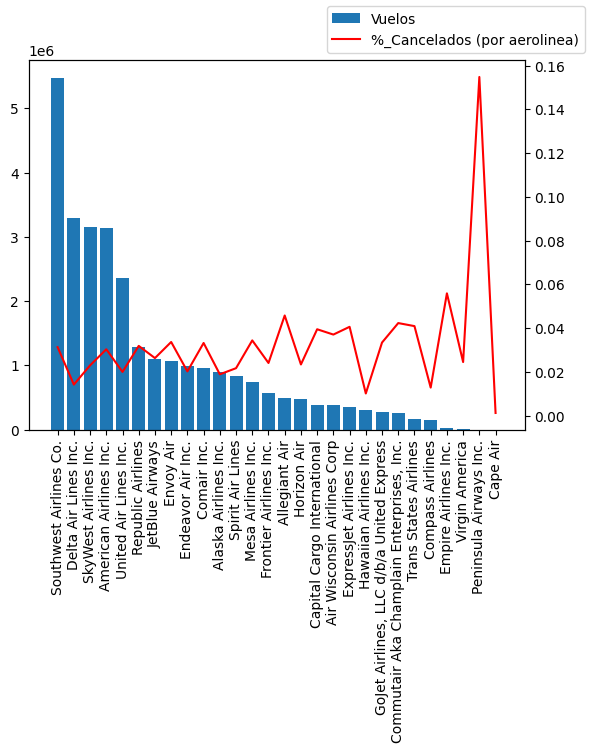

In [85]:
fig, ax = plt.subplots(1, facecolor = "white")

#airlines.plot(x="airline", y="vuelos", kind="bar", ax=ax, rot = 90)
#airlines.plot(y="%_Cancelados", linestyle = "-", ax=ax, 
#              color="r", rot = 90, secondary_y=True)

ax_2 = ax.twinx()

ax.bar(x=airlines["airline"], height=airlines["vuelos"], label = "Vuelos")
ax_2.plot(airlines["airline"], airlines["%_Cancelados"], color = "r"
          , label = "%_Cancelados (por aerolinea)")

ax.tick_params(axis="x", labelrotation = 90)

fig.legend()

plt.show()

In [80]:
origin = df.groupBy("Origin").agg({
    "Cancelled" : "avg",
    "*" : "count"
}).toPandas()

origin.rename(columns={"count(1)":"vuelos","avg(Cancelled)" : "%_Cancelados"}, inplace = True)

origin.sort_values(by="vuelos", ascending=False,inplace=True)

origin.reset_index(inplace=True, drop=True)

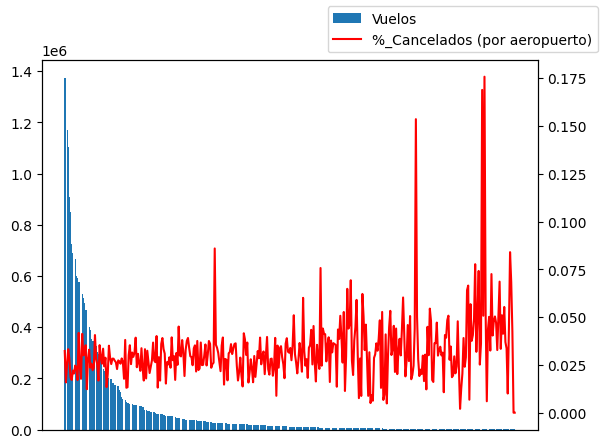

In [ ]:
fig, ax = plt.subplots(1, facecolor = "white")

ax_2 = ax.twinx()

ax.bar(x=origin["Origin"], height=origin["vuelos"], label = "Vuelos")
ax_2.plot(origin["Origin"], origin["%_Cancelados"], color = "r", label = "%_Cancelados (por aeropuerto)")

ax.tick_params(axis="x", labelrotation = 90)

fig.legend()

plt.xticks([])

plt.show()

In [86]:
dest = df.groupBy("Dest").agg({
    "Cancelled" : "avg",
    "*" : "count"
}).toPandas()

dest.rename(columns={"count(1)":"vuelos","avg(Cancelled)" : "%_Cancelados"}, inplace = True)

dest.sort_values(by="vuelos", ascending=False,inplace=True)

dest.reset_index(inplace=True, drop=True)

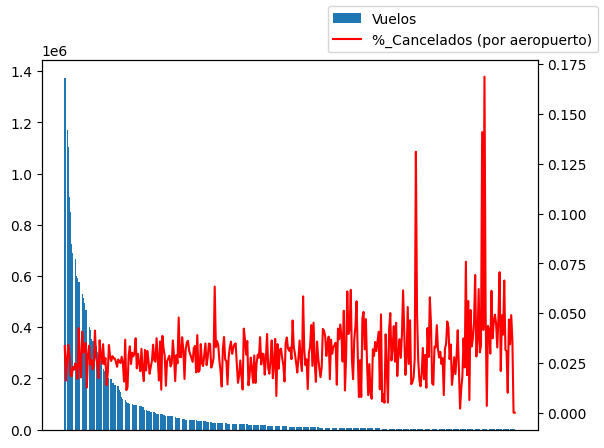

In [87]:
fig, ax = plt.subplots(1, facecolor = "white")

ax_2 = ax.twinx()

ax.bar(x=dest["Dest"], height=dest["vuelos"], label = "Vuelos")
ax_2.plot(dest["Dest"], dest["%_Cancelados"], color = "r", label = "%_Cancelados (por aeropuerto)")

ax.tick_params(axis="x", labelrotation = 90)

fig.legend()

plt.xticks([])

plt.show()

In [88]:
origin_state = df.groupBy("OriginStateName").agg({
    "Cancelled" : "avg",
    "*" : "count"
}).toPandas()

origin_state.rename(columns={"count(1)":"vuelos",
                             "avg(Cancelled)" : "%_Cancelados"}, inplace = True)

origin_state.sort_values(by="vuelos", ascending=False,inplace=True)

origin_state.reset_index(inplace=True, drop=True)

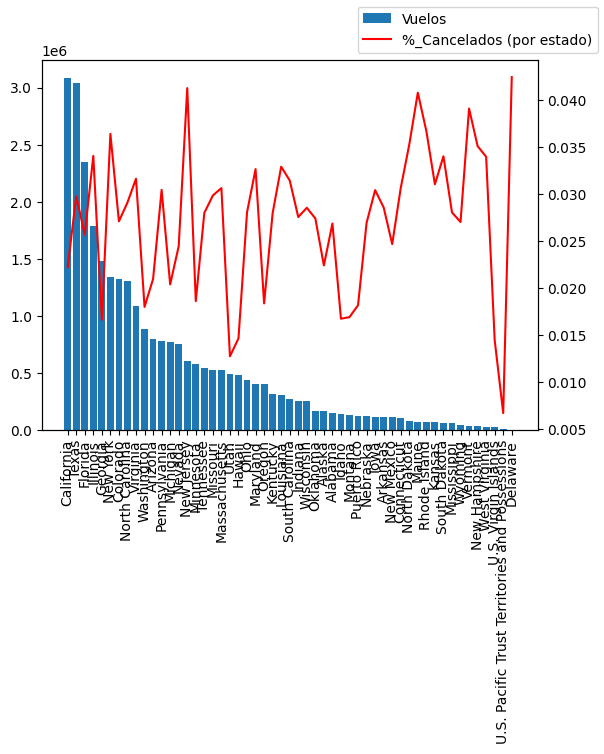

In [91]:
fig, ax = plt.subplots(1, facecolor = "white")

ax_2 = ax.twinx()

ax.bar(x=origin_state["OriginStateName"], height=origin_state["vuelos"], label = "Vuelos")
ax_2.plot(origin_state["OriginStateName"], origin_state["%_Cancelados"], color = "r"
          , label = "%_Cancelados (por estado)")

ax.tick_params(axis="x", labelrotation = 90)

fig.legend()

plt.show()

In [92]:
dest_state = df.groupBy("DestStateName").agg({
    "Cancelled" : "avg",
    "*" : "count"
}).toPandas()

dest_state.rename(columns={"count(1)":"vuelos",
                             "avg(Cancelled)" : "%_Cancelados"}, inplace = True)

dest_state.sort_values(by="vuelos", ascending=False,inplace=True)

dest_state.reset_index(inplace=True, drop=True)

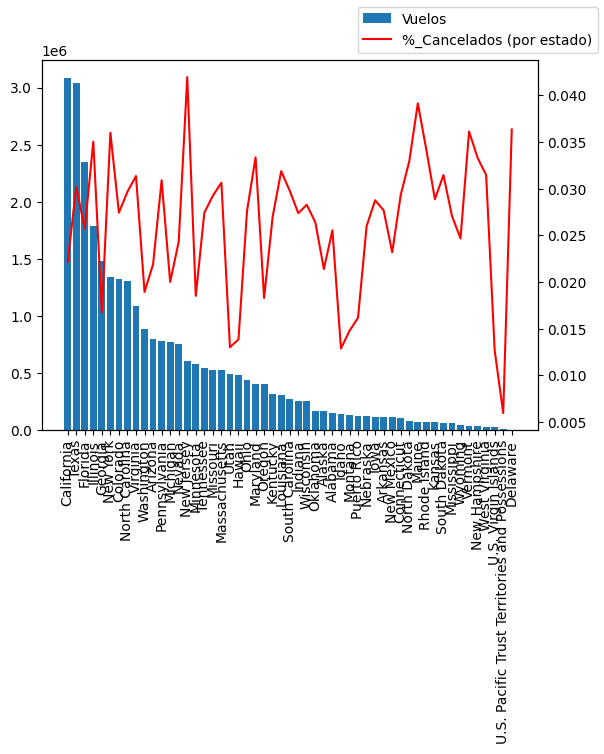

In [93]:
fig, ax = plt.subplots(1, facecolor = "white")

ax_2 = ax.twinx()

ax.bar(x=dest_state["DestStateName"], height=dest_state["vuelos"], label = "Vuelos")
ax_2.plot(dest_state["DestStateName"], dest_state["%_Cancelados"], color = "r"
          , label = "%_Cancelados (por estado)")

ax.tick_params(axis="x", labelrotation = 90)

fig.legend()

plt.show()

In [94]:
airplane_tail = df.groupBy("Tail_Number").agg({
    "Cancelled" : "avg",
    "*" : "count"
}).toPandas()

airplane_tail.rename(columns={"count(1)":"vuelos",
                             "avg(Cancelled)" : "%_Cancelados"}, inplace = True)

airplane_tail.sort_values(by="vuelos", ascending=False,inplace=True)

airplane_tail.reset_index(inplace=True, drop=True)

In [98]:
airplane_tail["Tail_Number"].replace({None:"Otros"}, inplace=True)

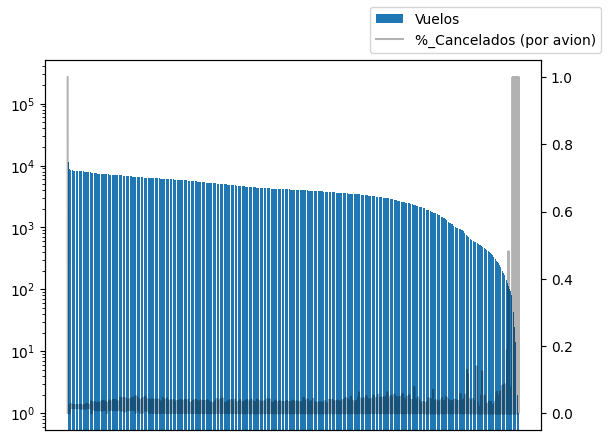

In [105]:
fig, ax = plt.subplots(1, facecolor = "white")

ax_2 = ax.twinx()

ax.bar(x=airplane_tail["Tail_Number"], height=airplane_tail["vuelos"], label = "Vuelos")
ax_2.plot(airplane_tail["Tail_Number"], airplane_tail["%_Cancelados"], color = "black"
          , label = "%_Cancelados (por avion)", alpha = 0.3)

ax.set_yscale("log")

ax.tick_params(axis="x", labelrotation = 90)

fig.legend()

plt.xticks([])

plt.show()

In [106]:
spark.stop()